[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MrMercado/QR_code_detector/blob/main/3.%20Deteccion%20QR.ipynb)

# Importamos las librerias necesarias para trabajar

In [ ]:
# Importamos Librerias
import numpy as np
import os                                       # para trabajar sobre directorios
import shutil                                   # para trabajar sobre directorios
import cv2                                      # Para leer y mostrar imagenes
from ultralytics import YOLO                    # Nuestro detector de codigos QR
from cv2 import QRCodeDetector                  # Para extraer codigo QR
from qreader import QReader

# Definimos funciones para procesar las imagenes

In [38]:
def load_model(model_path="./Modelos/xcerno30_QR_codes.pt"):
    """
    Carga el modelo YOLO.
    
    Args:
    - model_path (str): Ruta del modelo preentrenado.
    
    Returns:
    - model (YOLO): Modelo YOLO cargado.
    """
    return YOLO(model_path)

def detect_qr(model, image_path):
    """
    Detecta códigos QR en una imagen usando el modelo YOLO.
    
    Args:
    - model (YOLO): Modelo YOLO previamente cargado.
    - image_path (str): Ruta de la imagen a procesar.
    
    Returns:
    - qr_detected (ndarray): Imagen con códigos QR detectados.
    - cropped_qr_images (list): Lista de imágenes recortadas con códigos QR.
    """
    resultados = model.predict(image_path, save_crop=True)

    # almacenamos la imagen con el o los codigos qr detectados, opcional labels=True muestra la etiqueta de predicion
    qr_detected = resultados[0].plot(labels=False)

    # Eliminamos la carpeta que crea YOLO con los crop de los codigos QR para que en proximas predicciones no cambie el directorio y pueda mostrar errores
    try:
        path_crop = './runs/detect/predict/crops/qr_code/'
        # Guardamos cada uno de estos recortes en la lista imagenes
        cropped_qr_images = [cv2.imread(os.path.join(path_crop, img)) for img in os.listdir(path_crop) if img.endswith('.jpg')]
        # Una vez almacenados esta carpeta no es necesaria asi que se elimina
        shutil.rmtree('./runs', ignore_errors=True)
        
    except Exception as e:      # Si la carpeta no existe es porque el modelo no detecto QR en la imagen, entonces no se pueden hacer recortes

        cropped_qr_images = []
        
    return qr_detected, cropped_qr_images

def align_qr_image(img):
    """
    Alinea un código QR rotado en una imagen.
    
    Args:
    - img (ndarray): Imagen que contiene el código QR.
    
    Returns:
    - aligned_img (ndarray): Imagen alineada.
    """
    
    # Obtiene la dimensión más grande de la imagen (alto o ancho).
    max_dimension = max(img.shape[0], img.shape[1])
    
    # Crea una imagen cuadrada de ceros con la dimensión más grande obtenida. 
    # Esta imagen será de fondo negro.
    square_img = np.zeros((max_dimension, max_dimension, 3), dtype=np.uint8)
    square_img.fill(0)  # Rellenar con fondo negro

    # Calcula el desplazamiento necesario para centrar la imagen original (img) dentro de la imagen cuadrada.
    x_offset = (max_dimension - img.shape[1]) // 2
    y_offset = (max_dimension - img.shape[0]) // 2
    
    # Sitúa la imagen original en el centro de la imagen cuadrada.
    square_img[y_offset:y_offset + img.shape[0], x_offset:x_offset + img.shape[1]] = img

    # Convierte la imagen cuadrada a escala de grises para facilitar el procesamiento posterior.
    gray_img = cv2.cvtColor(square_img, cv2.COLOR_BGR2GRAY)

    # Inicializa el mejor ángulo de rotación a 0 y el mejor puntaje de alineación a infinito.
    best_angle = 0.0
    best_alignment_score = float('inf')

    # Itera sobre posibles ángulos de rotación desde -90 a 90 grados.
    for angle in range(-90, 91):
        # Calcula la matriz de rotación para el ángulo actual.
        rotation_matrix = cv2.getRotationMatrix2D((gray_img.shape[1] / 2, gray_img.shape[0] / 2), angle, 1)
        
        # Rota la imagen en escala de grises usando la matriz de rotación.
        rotated_img = cv2.warpAffine(gray_img, rotation_matrix, (gray_img.shape[1], gray_img.shape[0]))
        
        # Calcula los bordes verticales y horizontales de la imagen rotada.
        vertical_edges = cv2.Sobel(rotated_img, cv2.CV_64F, 1, 0, ksize=5)
        horizontal_edges = cv2.Sobel(rotated_img, cv2.CV_64F, 0, 1, ksize=5)
        
        # Suma el valor absoluto de todos los bordes para obtener un puntaje de alineación.
        alignment_score = np.sum(np.abs(vertical_edges)) + np.sum(np.abs(horizontal_edges))
        
        # Si el puntaje de alineación es menor que el mejor puntaje registrado, actualiza el mejor ángulo.
        if alignment_score < best_alignment_score:
            best_alignment_score = alignment_score
            best_angle = angle

    # Una vez que se ha encontrado el mejor ángulo, rota la imagen cuadrada original usando ese ángulo para alinearla.
    rotation_matrix = cv2.getRotationMatrix2D((square_img.shape[1] / 2, square_img.shape[0] / 2), best_angle, 1)
    aligned_img = cv2.warpAffine(square_img, rotation_matrix, (square_img.shape[1], square_img.shape[0]))

    # Devuelve la imagen alineada.
    return aligned_img

def decode_qr(img):
    """
    Decodifica el contenido de un código QR en una imagen.
    
    Args:
    - img (ndarray): Imagen que contiene el código QR.
    
    Returns:
    - decoded_text (str): Texto decodificado del código QR.
    """
    
    # Inicializa un objeto QReader, que es una biblioteca para leer códigos QR.
    qreader = QReader()
    
    # Inicializa un objeto QRCodeDetector de OpenCV, otra biblioteca para detectar y decodificar códigos QR.
    cv2_reader = QRCodeDetector()

    # Intenta decodificar el contenido del código QR usando QReader.
    qreader_out = qreader.detect_and_decode(image=img)
    
    # Intenta decodificar el contenido del código QR usando QRCodeDetector de OpenCV.
    cv2_out = cv2_reader.detectAndDecode(img=img)[0]

    # Verifica si QReader pudo decodificar el código QR y, en ese caso, devuelve el texto decodificado.
    if qreader_out and qreader_out[0]:
        return qreader_out[0]
    
    # Si QReader no pudo decodificarlo pero QRCodeDetector de OpenCV sí, devuelve el texto decodificado por OpenCV.
    elif cv2_out:
        return cv2_out
    
    # Si ninguno de los decodificadores pudo leer el código QR, devuelve None.
    else:
        return None

def display_image(img, title="Image"):
    """Displays an image within Jupyter."""
    is_color = len(img.shape) == 3
    if is_color:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_rgb = img
    pil_img = Image.fromarray(img_rgb)
    f = BytesIO()
    pil_img.save(f, "png")
    print(title)
    ipy_display(IPImage(data=f.getvalue(), format="png"))

# Instanciamos el modelo y predecimos sobre una imagen de muestra


image 1/1 C:\Users\esteb\Escritorio\carpeta\Trabajo\QR_Code_Detector\img_inferencia\1.jpg: 800x608 27 qr_codes, 282.7ms
Speed: 3.0ms preprocess, 282.7ms inference, 1.0ms postprocess per image at shape (1, 3, 800, 608)
Results saved to runs\detect\predict


Detector de codigos QR


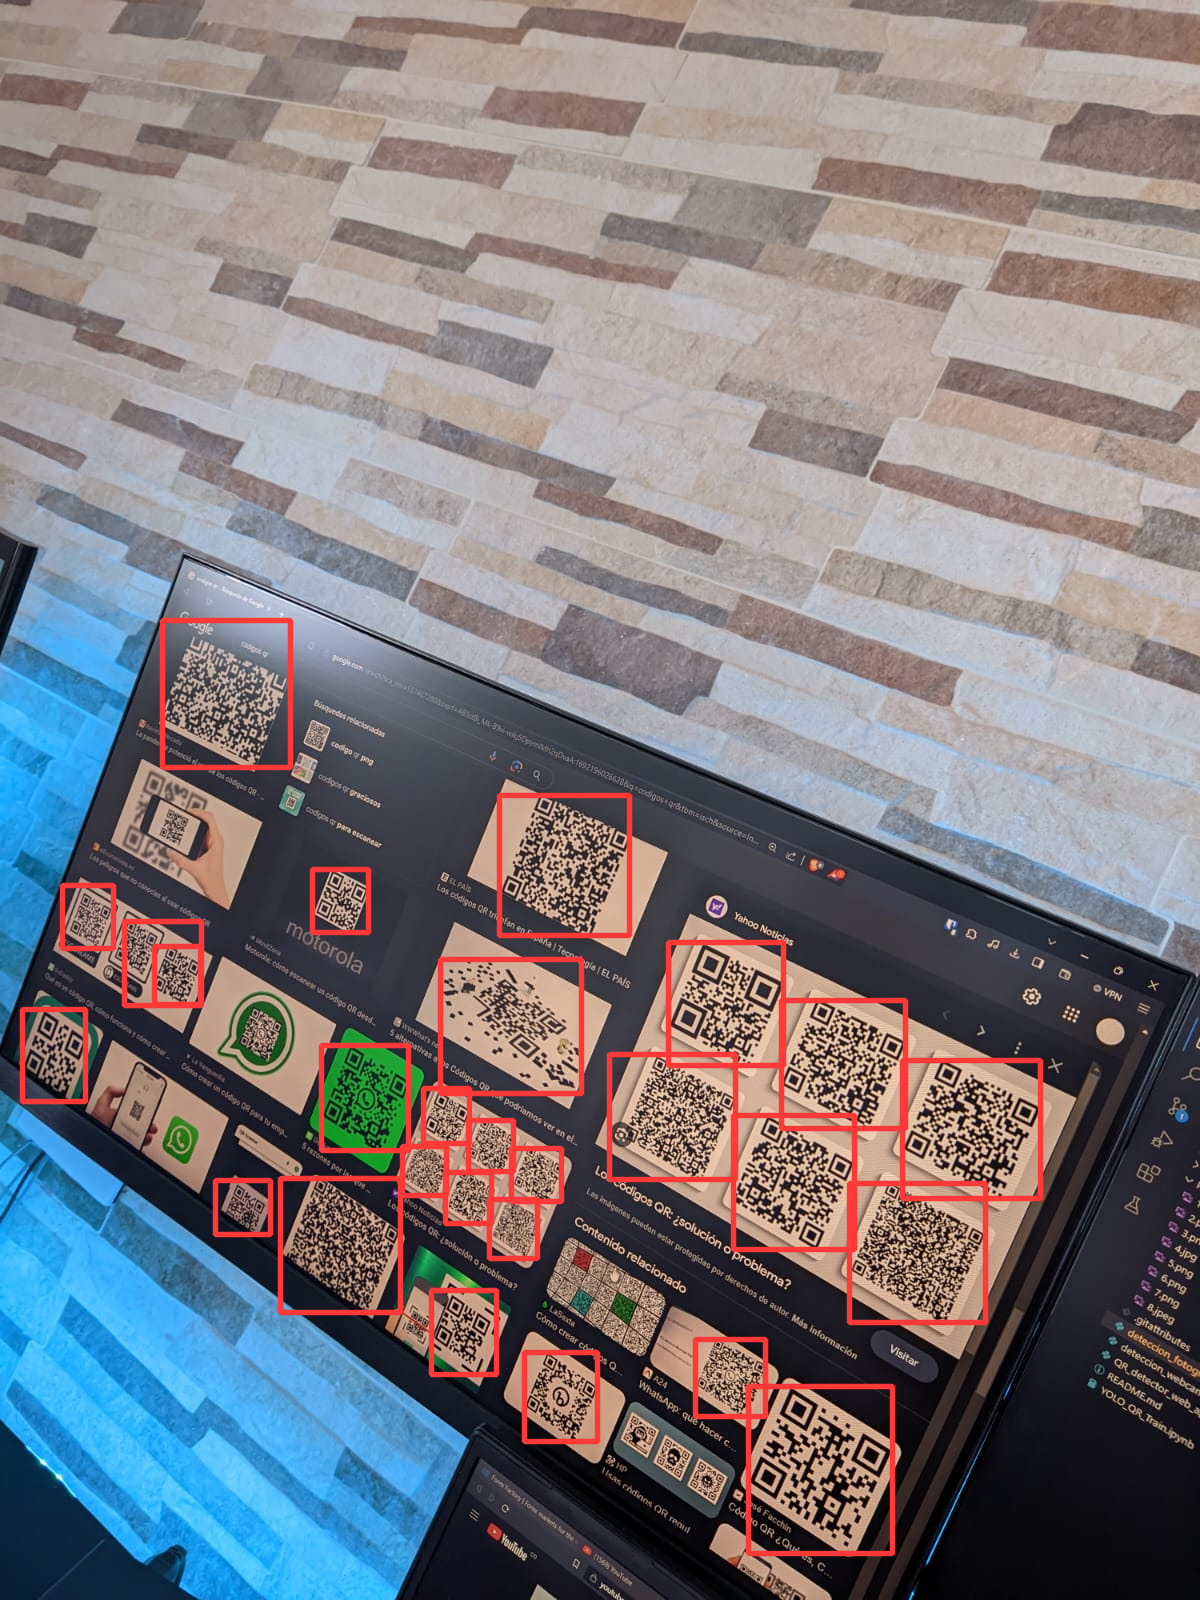

In [39]:
# Carga el modelo de detección de códigos QR.
model = load_model()

# Usa el modelo para detectar códigos QR en la imagen especificada.
# `qr_detected` es la imagen original con bounding boxes alrededor de los códigos QR detectados.
# `cropped_qr_images` es una lista de imágenes recortadas, cada una conteniendo un código QR detectado.
qr_detected, cropped_qr_images = detect_qr(model, './img_inferencia/1.jpg')

# Muestra la imagen con los bounding boxes alrededor de los códigos QR detectados.
display_image(qr_detected, "Detector de codigos QR")



Una imagen puede contener varios codigos QR, por esta razón se procesan todas las posibles detecciones de codigo QR que haya detectado nuestro modelo de Deep Learning.

En el siguiente bloque se extraen los codigos QR que detecto nuestro modelo, se procesa cada recorte para alinear y extraer el texto que contiene el codigo QR con decodificadores definidos previamente.


 Codigo QR extraido de la imagen


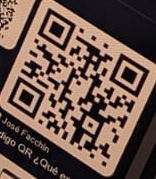

Imagen Alineada


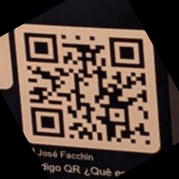

Fusing layers... 
IDetect.fuse
Imagen: 1 -> Texto decodificado: https://josefacchin.com/

 Codigo QR extraido de la imagen


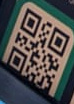

Imagen Alineada


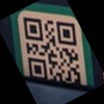

Fusing layers... 
IDetect.fuse
Imagen: 2 -> No se logró la decodificación del código QR.

 Codigo QR extraido de la imagen


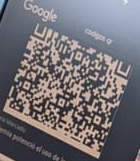

Imagen Alineada


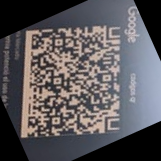

Fusing layers... 
IDetect.fuse
Imagen: 3 -> No se logró la decodificación del código QR.

 Codigo QR extraido de la imagen


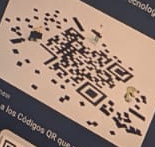

Imagen Alineada


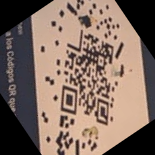

Fusing layers... 
IDetect.fuse
Imagen: 4 -> No se logró la decodificación del código QR.

 Codigo QR extraido de la imagen


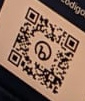

Imagen Alineada


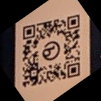

Fusing layers... 
IDetect.fuse
Imagen: 5 -> Texto decodificado: http://bit.ly/3lYwbDN?r=qr

 Codigo QR extraido de la imagen


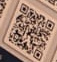

Imagen Alineada


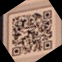

Fusing layers... 
IDetect.fuse
Imagen: 6 -> No se logró la decodificación del código QR.

 Codigo QR extraido de la imagen


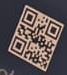

Imagen Alineada


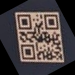

Fusing layers... 
IDetect.fuse
Imagen: 7 -> Texto decodificado: YKART

 Codigo QR extraido de la imagen


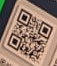

Imagen Alineada


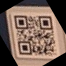

Fusing layers... 
IDetect.fuse
Imagen: 8 -> No se logró la decodificación del código QR.

 Codigo QR extraido de la imagen


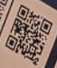

Imagen Alineada


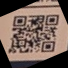

Fusing layers... 
IDetect.fuse
Imagen: 9 -> Texto decodificado: https://qrco.de/bbdbUy

 Codigo QR extraido de la imagen


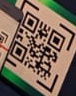

Imagen Alineada


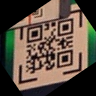

Fusing layers... 
IDetect.fuse
Imagen: 10 -> No se logró la decodificación del código QR.

 Codigo QR extraido de la imagen


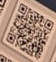

Imagen Alineada


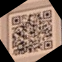

Fusing layers... 
IDetect.fuse
Imagen: 11 -> No se logró la decodificación del código QR.

 Codigo QR extraido de la imagen


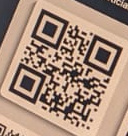

Imagen Alineada


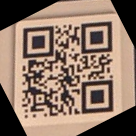

Fusing layers... 
IDetect.fuse
Imagen: 12 -> No se logró la decodificación del código QR.

 Codigo QR extraido de la imagen


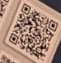

Imagen Alineada


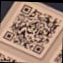

Fusing layers... 
IDetect.fuse
Imagen: 13 -> No se logró la decodificación del código QR.

 Codigo QR extraido de la imagen


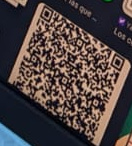

Imagen Alineada


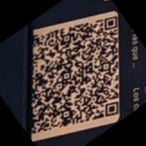

Fusing layers... 
IDetect.fuse
Imagen: 14 -> No se logró la decodificación del código QR.

 Codigo QR extraido de la imagen


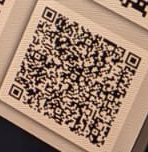

Imagen Alineada


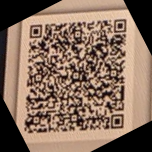

Fusing layers... 
IDetect.fuse
Imagen: 15 -> Texto decodificado: dfsgfddddddddddddddddddddddddgsdfgsfdgkjakljkdslahjksahdfkjashdkjhskajhfjksdhfaskjdhkashdfhkaksdjrewhrja

 Codigo QR extraido de la imagen


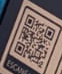

Imagen Alineada


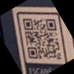

Fusing layers... 
IDetect.fuse
Imagen: 16 -> No se logró la decodificación del código QR.

 Codigo QR extraido de la imagen


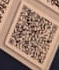

Imagen Alineada


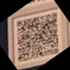

Fusing layers... 
IDetect.fuse
Imagen: 17 -> No se logró la decodificación del código QR.

 Codigo QR extraido de la imagen


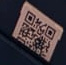

Imagen Alineada


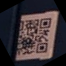

Fusing layers... 
IDetect.fuse
Imagen: 18 -> No se logró la decodificación del código QR.

 Codigo QR extraido de la imagen


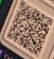

Imagen Alineada


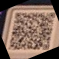

Fusing layers... 
IDetect.fuse
Imagen: 19 -> No se logró la decodificación del código QR.

 Codigo QR extraido de la imagen


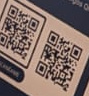

Imagen Alineada


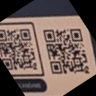

Fusing layers... 
IDetect.fuse
Imagen: 20 -> No se logró la decodificación del código QR.

 Codigo QR extraido de la imagen


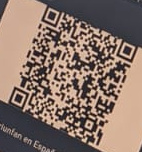

Imagen Alineada


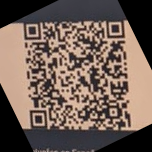

Fusing layers... 
IDetect.fuse
Imagen: 21 -> Texto decodificado: Estas leyendo QR-CODE, Una forma de hacer Marketing innovadora.Vivita el Blog www.jordifumado.com

 Codigo QR extraido de la imagen


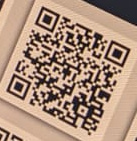

Imagen Alineada


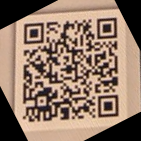

Fusing layers... 
IDetect.fuse
Imagen: 22 -> Texto decodificado: dfhgdfg546hfgh657ygfhbzs324gh563

 Codigo QR extraido de la imagen


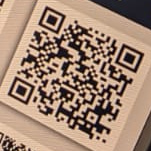

Imagen Alineada


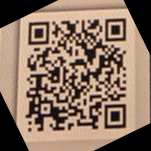

Fusing layers... 
IDetect.fuse
Imagen: 23 -> Texto decodificado: 23435fgsdfg356sdgfdg546fd

 Codigo QR extraido de la imagen


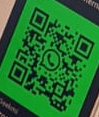

Imagen Alineada


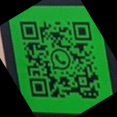

Fusing layers... 
IDetect.fuse
Imagen: 24 -> No se logró la decodificación del código QR.

 Codigo QR extraido de la imagen


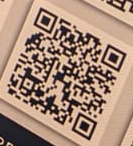

Imagen Alineada


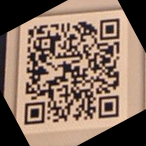

Fusing layers... 
IDetect.fuse
Imagen: 25 -> Texto decodificado: QR Data Random text for you

 Codigo QR extraido de la imagen


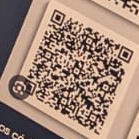

Imagen Alineada


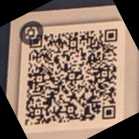

Fusing layers... 
IDetect.fuse
Imagen: 26 -> Texto decodificado: 234dfsgafdsg34905uuo534u50uklfjag09a84095ujisjhiofgh345097isjakfsjdf047057hgk

 Codigo QR extraido de la imagen


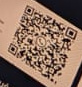

Imagen Alineada


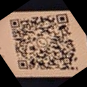

Fusing layers... 
IDetect.fuse
Imagen: 27 -> No se logró la decodificación del código QR.


In [40]:
# Si se detectaron códigos QR...
if cropped_qr_images:
    # ...itera sobre cada imagen recortada.
    for i, img in enumerate(cropped_qr_images):
        # Mostramos el codigo QR extraido
        display_image(img, "\n Codigo QR extraido de la imagen")
        # Alinea la imagen en caso de que el código QR esté rotado.
        aligned_img = align_qr_image(img)
        # Mostramos la iamgen alineada
        display_image(aligned_img, "Imagen Alineada")
        # Decodifica el contenido del código QR alineado.
        decoded_text = decode_qr(aligned_img)
        
        # Si se pudo decodificar el contenido del código QR, muestra el texto decodificado.
        if decoded_text:
            print(f"Imagen: {i+1} -> Texto decodificado: {decoded_text}")
        # Si no, indica que no se pudo decodificar.
        else:
            print(f"Imagen: {i+1} -> No se logró la decodificación del código QR.")
else:
    # Si no se detectaron códigos QR en la imagen, muestra un mensaje indicándolo.
    print('No se ha detectado codigos QR en la imagen')
